In [208]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingClassifier as BC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.neighbors.nearest_centroid import NearestCentroid as NC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import ExtraTreeClassifier as ExTC1
from sklearn.ensemble import ExtraTreesClassifier as ExTC2
from sklearn.neural_network import MLPClassifier as NNC
from sklearn.gaussian_process import kernels

In [209]:
classifiers = {
    "BC": BC,
    "SVC": SVC,
    "KNC": KNC,
    "NC": NC,
    "GPC": GPC,
    "DTC": DTC,
    "NNC": NNC,
    "ExTC1": ExTC1,
    "ExTC2": ExTC2,
}

In [210]:
R2 = pd.read_csv('./surrogate_performance/benchmark_test_R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark_train.csv', index_col=0)

In [211]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]
######################
loss = loss.loc[features_available_for]

In [212]:
# Training the selector

selector = classifiers['DTC']()
selector.fit(features.values, targets.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [213]:
# Engineering features

engineering_features = pd.read_csv("./features/engineering_train.csv", index_col=0)
engineering_features = engineering_features[features.columns]
engineering_features = engineering_features.dropna()

In [214]:
# Engineering R2

engineering_R2 = pd.read_csv('./surrogate_performance/engineering_test_R^2.csv', index_col=0)
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
engineering_loss = -engineering_R2.sub(engineering_R2.max(axis=1), axis=0)
engineering_targets = engineering_loss.idxmin(axis=1)
# Getting data that is avalable in both targets and features
features_available_for = engineering_targets.index.intersection(engineering_features.index)
engineering_targets = engineering_targets.loc[features_available_for]
engineering_loss = engineering_loss.loc[features_available_for]

<IPython.core.display.Javascript object>


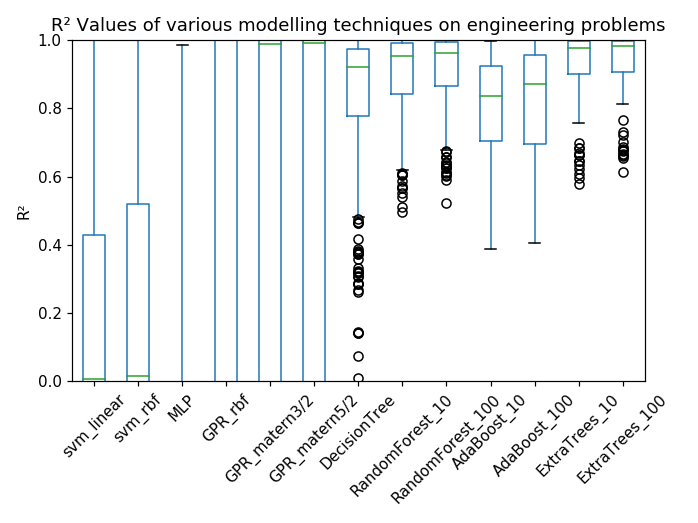

In [215]:
engineering_R2.plot.box(rot=45)
plt.ylim([0,1])
plt.ylabel('R²')
plt.title('R² Values of various modelling techniques on engineering problems')
plt.tight_layout()

In [216]:
# Selector Predictions

engineering_predictions = selector.predict(engineering_features)
engineering_predictions = pd.DataFrame(engineering_predictions, index=engineering_features.index, columns=['Prediction'])

In [217]:
metrics.confusion_matrix(engineering_targets, engineering_predictions)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  7,  0,  0,  0,  0,  0,  8,  1],
       [ 0,  1, 53,  0,  0,  0,  0,  3, 43,  4],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7, 18,  0, 10,  2,  5,  1,  0,  0],
       [ 0,  3, 30,  0, 18,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [218]:
engineering_loss_prediction = pd.DataFrame(columns=['Prediction'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_prediction['Prediction'].at[comp_id] = engineering_loss[engineering_predictions.loc[comp_id]].loc[comp_id]

In [219]:
engineering_loss.sort_index(axis=1, inplace=True)
engineering_loss = engineering_loss.join(engineering_loss_prediction)

In [220]:
cv_scores_mean = pd.read_csv("./surrogate_performance/engineeringCV-score-mean.csv", index_col=0)
cv_scores_mean = cv_scores_mean.loc[features_available_for]
cv_scores_max = pd.read_csv("./surrogate_performance/engineeringCV-score-max.csv", index_col=0)
cv_scores_max = cv_scores_max.loc[features_available_for]

In [221]:
cv_mean_best = cv_scores_mean.idxmax(axis=1)
cv_max_best = cv_scores_max.idxmax(axis=1)

In [222]:
metrics.confusion_matrix(engineering_targets, cv_mean_best)

array([[  0,   0,   1,   0,   0,   0],
       [  0,   0,  16,   0,   0,   0],
       [  0,   3, 101,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,  40,   3],
       [  0,   0,   2,   0,   7,  46]])

In [223]:
metrics.confusion_matrix(engineering_targets, cv_max_best)

array([[ 0,  0,  1,  0,  0,  0],
       [ 0,  0, 16,  0,  0,  0],
       [ 0,  8, 96,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1, 37,  5],
       [ 0,  0,  0,  0,  6, 49]])

In [224]:
engineering_loss_predictionCVmax = pd.DataFrame(columns=['PredictionCVmax'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmax['PredictionCVmax'].at[comp_id] = engineering_loss[cv_max_best.loc[comp_id]].loc[comp_id]

    
engineering_loss_predictionCVmean = pd.DataFrame(columns=['PredictionCVmean'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmean['PredictionCVmean'].at[comp_id] = engineering_loss[cv_mean_best.loc[comp_id]].loc[comp_id]

In [225]:
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmax)
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmean)

## Plots

<IPython.core.display.Javascript object>


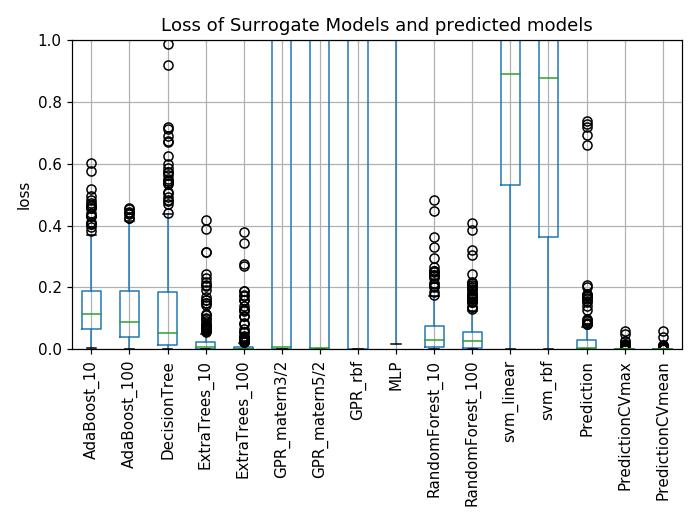

In [227]:
engg_loss_chart = engineering_loss.boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
plt.ylabel('loss')
engg_loss_chart.set_ylim([0,1])
plt.tight_layout()
engg_loss_chart

<IPython.core.display.Javascript object>


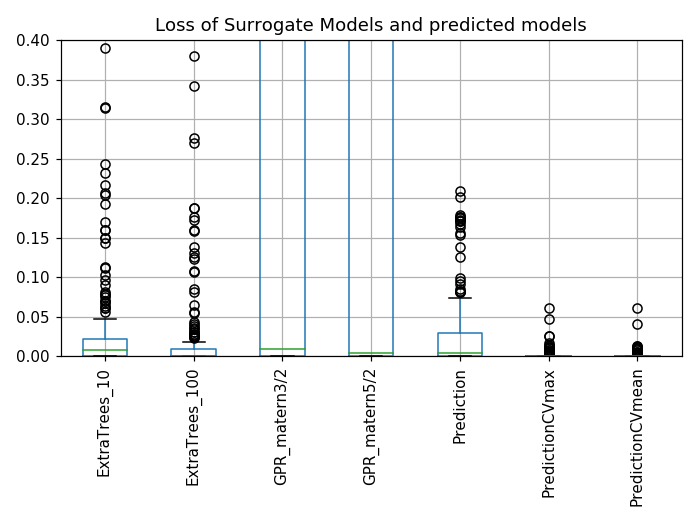

In [228]:
engg_loss_chart = engineering_loss[['ExtraTrees_10','ExtraTrees_100', 'GPR_matern3/2','GPR_matern5/2', 'Prediction', 'PredictionCVmax', 'PredictionCVmean']].boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
engg_loss_chart.set_ylim([0,0.4])
plt.tight_layout()
engg_loss_chart

In [229]:
engineering_loss.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,PredictionCVmax,PredictionCVmean
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.143484,0.126218,0.143516,0.030747,0.019198,32.678621,3.293388e+01,51.867306,50.718889,0.060275,5.014302e-02,0.742889,0.745787,0.158825,1.853663,0.000985
std,0.127099,0.116383,0.200822,0.063869,0.054142,70.760605,7.074352e+01,104.771179,94.792050,0.081354,7.069319e-02,0.414954,0.417118,1.140974,27.474476,0.005252
min,0.002814,0.000751,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00,-0.000000,0.015716,0.000001,4.024629e-07,0.000134,0.000840,-0.000000,-0.000000,-0.000000
25%,0.064697,0.039762,0.013056,0.000489,-0.000000,0.000080,1.486147e-07,0.000003,1.105077,0.006359,4.870317e-03,0.529837,0.364148,-0.000000,-0.000000,-0.000000
50%,0.112318,0.086541,0.052876,0.007808,0.000001,0.008446,4.509092e-03,1.269717,5.480672,0.030970,2.502213e-02,0.888797,0.878850,0.003348,-0.000000,-0.000000
75%,0.187375,0.189445,0.183484,0.021986,0.008571,56.258021,5.625802e+01,58.535990,57.224819,0.074130,5.473499e-02,0.999951,1.000102,0.029337,-0.000000,-0.000000
max,0.603764,0.455608,0.987727,0.417497,0.380364,309.539709,3.095397e+02,407.513931,356.267120,0.483752,4.071379e-01,2.478848,2.478848,14.799081,407.513656,0.060316
